# Attempt at embedding latent space of MNIST Autoencoder onto CIFAR-10 Autoencoder

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from itertools import cycle
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
# Parameter
latent_dim_mnist = 32
latent_dim_cifar = 128
# lambda_align = 0.1
batch_size = 64

In [3]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

mnist_loader = DataLoader(datasets.MNIST("../data", train=True, download=True, transform=transform_mnist), batch_size=batch_size, shuffle=True)
cifar_loader = DataLoader(datasets.CIFAR10("../data", train=True, download=True, transform=transform_cifar), batch_size=batch_size, shuffle=True)

In [5]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon.view(-1, 1, 28, 28)

In [6]:
class CIFAR_Autoencoder(nn.Module):
    def __init__(self, latent_dim_full):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*8*8, latent_dim_full)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_full, 64*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using Cuda")

mnist_model = MNIST_Autoencoder(latent_dim_mnist).to(device)
cifar_model = CIFAR_Autoencoder(latent_dim_cifar).to(device)

mnist_losses = []
cifar_losses = []

optimizer_mnist = optim.Adam(mnist_model.parameters(), lr=1e-3)
optimizer_cifar = optim.Adam(cifar_model.parameters(), lr=1e-3)

losses = []
optimizer = optim.Adam(list(mnist_model.parameters()) + list(cifar_model.parameters()), lr=1e-3)

mse = nn.MSELoss()

Using Cuda


NameError: name 'latent_dim_mnist' is not defined

# 1 I DON'T know what I'm doing

In [ ]:
print("MNIST_Autoencoder")
for epoch in range(5):
    mnist_model.train()
    total_loss = 0
    for x, _ in mnist_loader:
        x = x.to(device)
        z, x_recon = mnist_model(x)
        loss = mse(x_recon, x)

        optimizer_mnist.zero_grad()
        loss.backward()
        optimizer_mnist.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5, Total Loss: {total_loss:.4f}, AVG Loss: {(total_loss / len(mnist_loader)):.4f}")

mnist_model.eval()
for param in mnist_model.parameters():
    param.requires_grad = False

print("CIFAR_Autoencoder")
for epoch in range(10):
    cifar_model.train()
    total_loss = 0
    for (cifar_x, _), (mnist_x, _) in zip(cifar_loader, cycle(mnist_loader)):
        cifar_x, mnist_x = cifar_x.to(device), mnist_x.to(device)
        min_batch = min(cifar_x.size(0), mnist_x.size(0))
        cifar_x, mnist_x = cifar_x[:min_batch], mnist_x[:min_batch]

        with torch.no_grad():
            z_mnist, _ = mnist_model(mnist_x)

        z_cifar, cifar_recon = cifar_model(cifar_x)
        recon_loss = mse(cifar_recon, cifar_x)
        align_loss = mse(z_cifar[:, :latent_dim_mnist], z_mnist)
        loss = recon_loss + lambda_align * align_loss

        optimizer_cifar.zero_grad()
        loss.backward()
        optimizer_cifar.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Total Loss: {total_loss:.4f}, AVG Loss: {(total_loss / len(cifar_loader)):.4f}")

# torch.save(mnist_model.state_dict(), "../output/v10/mnist_autoencoder_weights.pth")
# torch.save(mnist_model, "../output/v10/mnist_autoencoder_model.pth")
# torch.save(cifar_model.state_dict(), "../output/v10/cifar_autoencoder_weights.pth")
# torch.save(cifar_model, "../output/v10/cifar_autoencoder_model.pth")

MNIST_Autoencoder
Epoch 1/5, Total Loss: 879.6489, AVG Loss: 0.9378
Epoch 2/5, Total Loss: 867.9946, AVG Loss: 0.9254
Epoch 3/5, Total Loss: 867.9952, AVG Loss: 0.9254
Epoch 4/5, Total Loss: 867.9942, AVG Loss: 0.9254
Epoch 5/5, Total Loss: 867.9962, AVG Loss: 0.9254
CIFAR_Autoencoder
Epoch 1, Loss: 1895.1870
Epoch 2, Loss: 848.7784
Epoch 3, Loss: 795.2706
Epoch 4, Loss: 787.4969
Epoch 5, Loss: 775.1946
Epoch 6, Loss: 781.0500
Epoch 7, Loss: 770.7001
Epoch 8, Loss: 767.2280
Epoch 9, Loss: 769.3594
Epoch 10, Loss: 765.7800


In [9]:
# Visualization
def reconstruct_with_truncation(model, images, dim_trunc):
    z, _ = model(images)
    z_trunc = torch.zeros_like(z)
    z_trunc[:, :dim_trunc] = z[:, :dim_trunc]
    x_recon = model.decoder(z_trunc)
    return x_recon

# 2 CUT & PASTE

In [ ]:
# Joint Train
for epoch in range(20):
    mnist_model.train()
    cifar_model.train()
    total_loss = 0
    for (cifar_x, _), (mnist_x, _) in zip(cifar_loader, cycle(mnist_loader)):
        cifar_x, mnist_x = cifar_x.to(device), mnist_x.to(device)
        min_batch = min(cifar_x.size(0), mnist_x.size(0))
        cifar_x, mnist_x = cifar_x[:min_batch], mnist_x[:min_batch]

        # Encode both datasets
        z_mnist, _ = mnist_model(mnist_x)
        z_cifar, _ = cifar_model(cifar_x)

        # Merge latent spaces
        z_joint = torch.zeros_like(z_cifar)
        z_joint[:, :latent_dim_mnist] = z_mnist
        z_joint[:, latent_dim_mnist:] = z_cifar[:, latent_dim_mnist:]

        recon_mnist = mnist_model.decoder(z_joint[:, :latent_dim_mnist])
        recon_mnist = recon_mnist.view(-1, 1, 28, 28)
        recon_cifar = cifar_model.decoder(z_joint)

        loss_mnist = mse(recon_mnist, mnist_x)
        loss_cifar = mse(recon_cifar, cifar_x)
        loss = loss_mnist + loss_cifar

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/20, Total Joint Loss: {total_loss:.4f}, AVG Loss: {(total_loss / len(cifar_loader)):.4f}")

Epoch 1/20, Total Joint Loss: 938.0645, AVG Loss: 1.1996
Epoch 2/20, Total Joint Loss: 923.8044, AVG Loss: 1.1813
Epoch 3/20, Total Joint Loss: 923.8622, AVG Loss: 1.1814
Epoch 4/20, Total Joint Loss: 923.8418, AVG Loss: 1.1814
Epoch 5/20, Total Joint Loss: 923.7985, AVG Loss: 1.1813
Epoch 6/20, Total Joint Loss: 923.8131, AVG Loss: 1.1813
Epoch 7/20, Total Joint Loss: 923.8088, AVG Loss: 1.1813
Epoch 8/20, Total Joint Loss: 923.8819, AVG Loss: 1.1814
Epoch 9/20, Total Joint Loss: 871.6710, AVG Loss: 1.1147
Epoch 10/20, Total Joint Loss: 831.4400, AVG Loss: 1.0632
Epoch 11/20, Total Joint Loss: 813.6426, AVG Loss: 1.0405
Epoch 12/20, Total Joint Loss: 807.3023, AVG Loss: 1.0324
Epoch 13/20, Total Joint Loss: 803.3639, AVG Loss: 1.0273
Epoch 14/20, Total Joint Loss: 800.7684, AVG Loss: 1.0240
Epoch 15/20, Total Joint Loss: 798.7195, AVG Loss: 1.0214
Epoch 16/20, Total Joint Loss: 797.0895, AVG Loss: 1.0193
Epoch 17/20, Total Joint Loss: 795.8146, AVG Loss: 1.0177
Epoch 18/20, Total Join

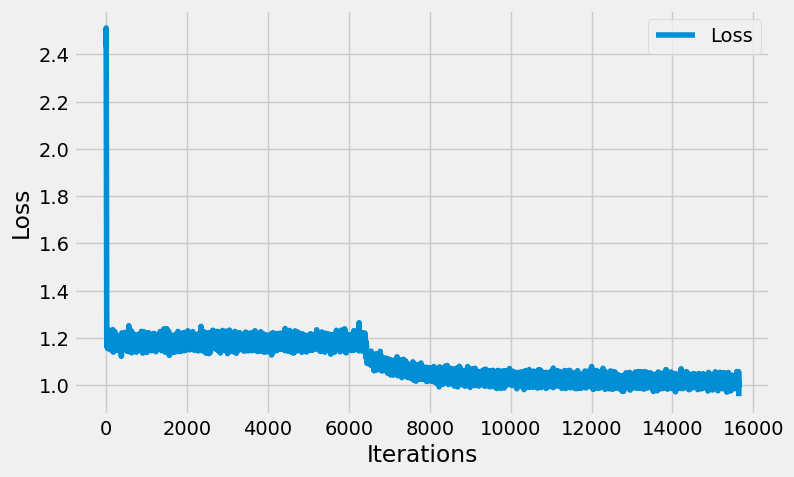

In [11]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [8]:
torch.save(mnist_model.state_dict(), "../output/v10/mnist_autoencoder_weights.pth")
torch.save(mnist_model, "../output/v10/mnist_autoencoder_model.pth")
torch.save(cifar_model.state_dict(), "../output/v10/cifar_autoencoder_weights.pth")
torch.save(cifar_model, "../output/v10/cifar_autoencoder_model.pth")

In [9]:
mnist_model = MNIST_Autoencoder(latent_dim_mnist).to(device)
mnist_model.load_state_dict(torch.load("../output/v10/mnist_autoencoder_weights.pth"))
mnist_model.eval()

cifar_model = CIFAR_Autoencoder(latent_dim_cifar).to(device)
cifar_model.load_state_dict(torch.load("../output/v10/cifar_autoencoder_weights.pth"))
cifar_model.eval()

NameError: name 'latent_dim_mnist' is not defined

In [10]:
mnist_model = torch.load("../output/v10/mnist_autoencoder_model.pth")
mnist_model.to(device).eval()

cifar_model = torch.load("../output/v10/cifar_autoencoder_model.pth")
cifar_model.to(device).eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.MNIST_Autoencoder was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.MNIST_Autoencoder])` or the `torch.serialization.safe_globals([__main__.MNIST_Autoencoder])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [11]:
def show_grid(images, title, nrow=8):
    grid = make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()


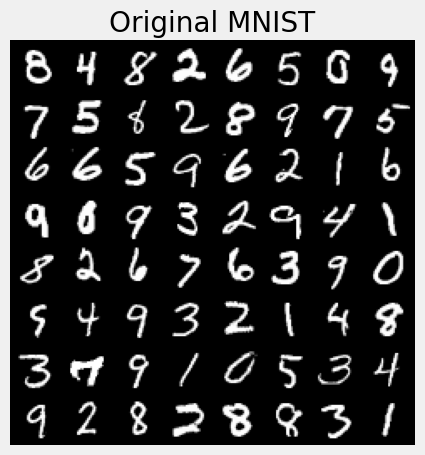

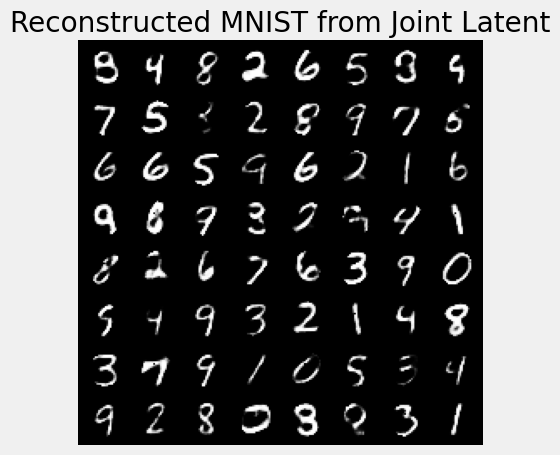

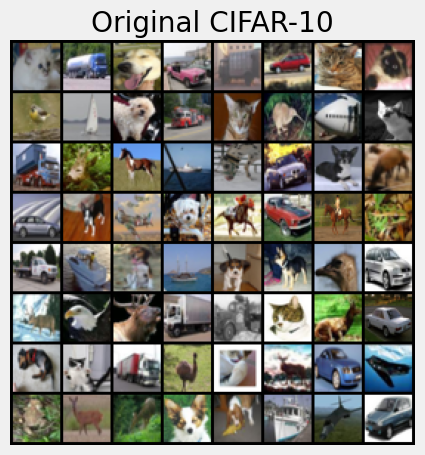

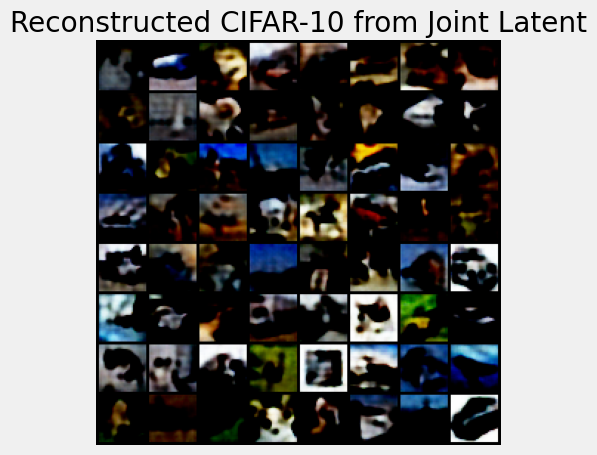

In [15]:
# Visualize reconstructions
mnist_model.eval()
cifar_model.eval()
with torch.no_grad():
    sample_mnist, _ = next(iter(mnist_loader))
    sample_cifar, _ = next(iter(cifar_loader))
    sample_mnist, sample_cifar = sample_mnist.to(device), sample_cifar.to(device)

    z_mnist, _ = mnist_model(sample_mnist)
    z_cifar, _ = cifar_model(sample_cifar)
    z_joint = torch.zeros_like(z_cifar)
    z_joint[:, :latent_dim_mnist] = z_mnist
    z_joint[:, latent_dim_mnist:] = z_cifar[:, latent_dim_mnist:]

    recon_mnist = mnist_model.decoder(z_joint[:, :latent_dim_mnist]).view(-1, 1, 28, 28)
    recon_cifar = cifar_model.decoder(z_joint)

show_grid(sample_mnist, "Original MNIST")
show_grid(recon_mnist, "Reconstructed MNIST from Joint Latent")

show_grid(sample_cifar, "Original CIFAR-10")
show_grid(recon_cifar, "Reconstructed CIFAR-10 from Joint Latent")


# 3 Project MNIST onto CIFAR

In [7]:
mnist_proj = nn.Linear(32, 128).to(device)
mnist_proj_back = nn.Linear(128, 32).to(device)

In [8]:
# Joint Train
for epoch in range(20):
    mnist_model.train()
    cifar_model.train()
    total_loss = 0
    for (cifar_x, _), (mnist_x, _) in zip(cifar_loader, cycle(mnist_loader)):
        cifar_x, mnist_x = cifar_x.to(device), mnist_x.to(device)
        min_batch = min(cifar_x.size(0), mnist_x.size(0))
        cifar_x, mnist_x = cifar_x[:min_batch], mnist_x[:min_batch]

        z_mnist, _ = mnist_model(mnist_x)   # shape: [64, 32]
        z_cifar, _ = cifar_model(cifar_x)   # shape: [64, 128]

        z_mnist_proj = mnist_proj(z_mnist)  # shape: [64, 128]

        z_joint = (z_mnist_proj + z_cifar) / 2

        z_mnist_recon = mnist_proj_back(z_joint)  

        recon_mnist = mnist_model.decoder(z_mnist_recon)
        recon_mnist = recon_mnist.view(-1, 1, 28, 28)
        recon_cifar = cifar_model.decoder(z_joint)

        loss_mnist = mse(recon_mnist, mnist_x)
        loss_cifar = mse(recon_cifar, cifar_x)
        loss = loss_mnist + loss_cifar

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/20, Total Joint Loss: {total_loss:.4f}, AVG Loss: {(total_loss / len(cifar_loader)):.4f}")

Epoch 1/20, Total Joint Loss: 936.0238, AVG Loss: 1.1970
Epoch 2/20, Total Joint Loss: 923.7927, AVG Loss: 1.1813
Epoch 3/20, Total Joint Loss: 923.8465, AVG Loss: 1.1814
Epoch 4/20, Total Joint Loss: 923.8533, AVG Loss: 1.1814
Epoch 5/20, Total Joint Loss: 923.8127, AVG Loss: 1.1813
Epoch 6/20, Total Joint Loss: 923.7981, AVG Loss: 1.1813
Epoch 7/20, Total Joint Loss: 923.8203, AVG Loss: 1.1814
Epoch 8/20, Total Joint Loss: 923.8602, AVG Loss: 1.1814
Epoch 9/20, Total Joint Loss: 923.8020, AVG Loss: 1.1813
Epoch 10/20, Total Joint Loss: 923.8028, AVG Loss: 1.1813
Epoch 11/20, Total Joint Loss: 923.8514, AVG Loss: 1.1814
Epoch 12/20, Total Joint Loss: 923.8492, AVG Loss: 1.1814
Epoch 13/20, Total Joint Loss: 923.8286, AVG Loss: 1.1814
Epoch 14/20, Total Joint Loss: 923.7927, AVG Loss: 1.1813
Epoch 15/20, Total Joint Loss: 923.7967, AVG Loss: 1.1813
Epoch 16/20, Total Joint Loss: 923.8474, AVG Loss: 1.1814
Epoch 17/20, Total Joint Loss: 923.8612, AVG Loss: 1.1814
Epoch 18/20, Total Join

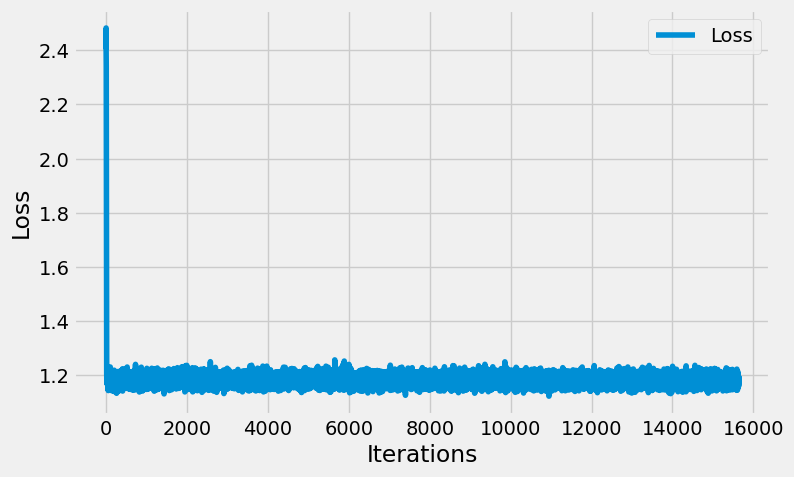

In [9]:
torch.save(mnist_model.state_dict(), "../output/v10/mnist_autoencoder_weights_proj.pth")
torch.save(mnist_model, "../output/v10/mnist_autoencoder_model_proj.pth")
torch.save(cifar_model.state_dict(), "../output/v10/cifar_autoencoder_weights_proj.pth")
torch.save(cifar_model, "../output/v10/cifar_autoencoder_model_proj.pth")

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

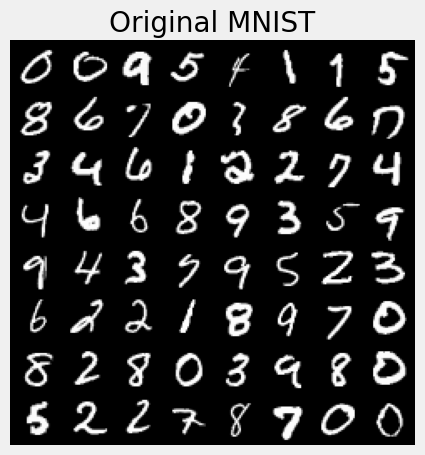

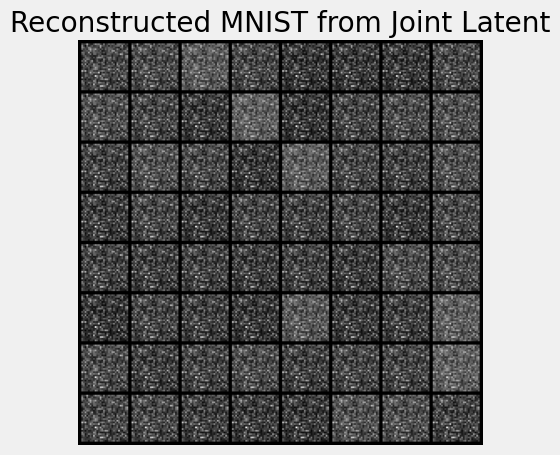

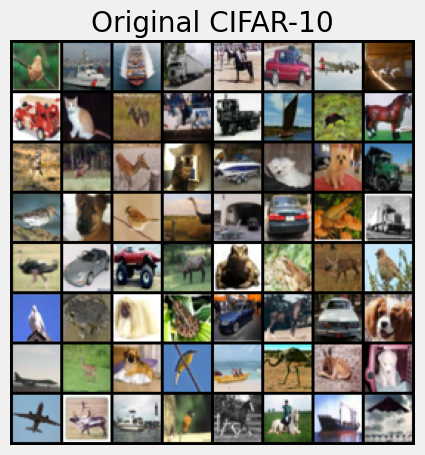

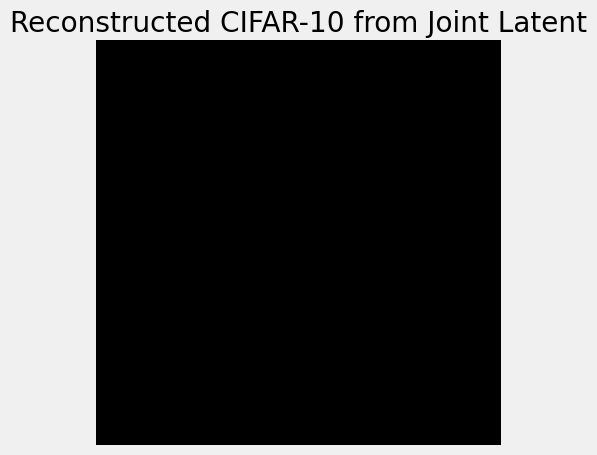

In [12]:
# Visualize reconstructions
mnist_model.eval()
cifar_model.eval()
with torch.no_grad():
    sample_mnist, _ = next(iter(mnist_loader))
    sample_cifar, _ = next(iter(cifar_loader))
    sample_mnist, sample_cifar = sample_mnist.to(device), sample_cifar.to(device)

    z_mnist, _ = mnist_model(sample_mnist)
    z_cifar, _ = cifar_model(sample_cifar)
    z_joint = torch.zeros_like(z_cifar)
    z_joint[:, :latent_dim_mnist] = z_mnist
    z_joint[:, latent_dim_mnist:] = z_cifar[:, latent_dim_mnist:]

    recon_mnist = mnist_model.decoder(z_joint[:, :latent_dim_mnist]).view(-1, 1, 28, 28)
    recon_cifar = cifar_model.decoder(z_joint)

show_grid(sample_mnist, "Original MNIST")
show_grid(recon_mnist, "Reconstructed MNIST from Joint Latent")

show_grid(sample_cifar, "Original CIFAR-10")
show_grid(recon_cifar, "Reconstructed CIFAR-10 from Joint Latent")


# 4